In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
random.seed(1)

# k-mer word size
kmer_size = 3

# protein/sst3 sequence size limts
min_len = 100
max_len = 300

In [3]:
# updated data with 25% identity and 2.0 Angstrom cutoffs 
ss_2022_25_20 = pd.read_csv('protein_data/2022-12-17-pdb-intersect-pisces_pc25_r2.0.csv')

# updated data with 25% identity and 2.5 Angstrom cutoffs 
ss_2022_25_25 = pd.read_csv('protein_data/2022-12-17-pdb-intersect-pisces_pc25_r2.5.csv')

# updated data with 30% identity and 2.5 Angstrom cutoffs 
ss_2022_30_25 = pd.read_csv('protein_data/2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')

# the full, unfiltered dataset from mid-2022
ss_cleaned = pd.read_csv('protein_data/2022-08-03-ss.cleaned.csv')
ss_cleaned.drop(ss_cleaned[ss_cleaned['has_nonstd_aa']].index, inplace=True)
ss_cleaned.drop_duplicates(subset=['seq'], inplace=True)

In [7]:
ss_2022_30_25.head()

,pdb_id,chain_code,seq,sst8,sst3,len_x,has_nonstd_aa,len_y,method,resol,rfac,freerfac
0,5D8V,A,AAPANAVTADDPTAIALKYNQDATKSERVAAARPGLPPEEQHCANC...,CCCTTBCCTTCHHHHHHTCBSSGGGSCHHHHCCTTSCGGGCCGGGB...,CCCCCECCCCCHHHHHHCCECCHHHCCHHHHCCCCCCHHHCCHHHE...,83,False,83,XRAY,0.48,0.072,0.078
1,3NIR,A,TTCCPSIVARSNFNVCRLPGTPEALCATYTGCIIIPGATCPGDYAN,CEECSSHHHHHHHHHHHTTTCCHHHHHHHHSCEECSSSCCCTTSCC,CEECCCHHHHHHHHHHHCCCCCHHHHHHHHCCEECCCCCCCCCCCC,46,False,46,XRAY,0.48,0.127,NaN
2,5NW3,A,MAKWVCKICGYIYDEDAGDPDNGISPGTKFEELPDDWVCPICGAPK...,CCEEEETTTCCEEETTTCBGGGTBCTTCCGGGSCTTCBCTTTCCBG...,CCEEEECCCCCEEECCCCEHHHCECCCCCHHHCCCCCECCCCCCEH...,54,False,54,XRAY,0.59,0.135,0.146
3,1UCS,A,NKASVVANQLIPINTALTLIMMKAEVVTPMGIPAEEIPKLVGMQVN...,CCCEEEESSCBCTTCBCCGGGEEEECCSSCCSBGGGHHHHTTCBBS...,CCCEEEECCCECCCCECCHHHEEEECCCCCCCEHHHHHHHCCCEEC...,64,False,64,XRAY,0.62,0.139,0.155
4,3X2M,A,ATGGYVQQATGQASFTMYSGCGSPACGKAASGFTAAINQLAFGSAP...,CGGGCCCCSEEEEEEEEESCCSSCTTSCCBSSCEEEEEHHHHTSCT...,CHHHCCCCCEEEEEEEEECCCCCCCCCCCECCCEEEEEHHHHCCCC...,180,False,180,XRAY,0.64,0.122,0.129


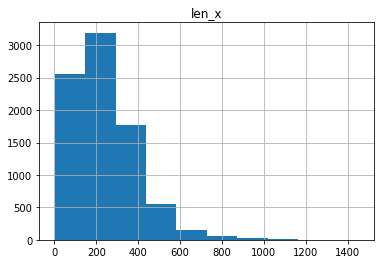

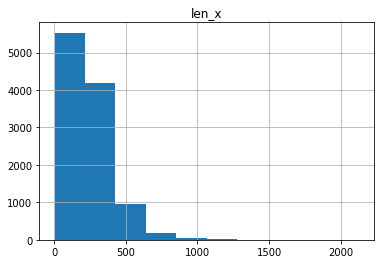

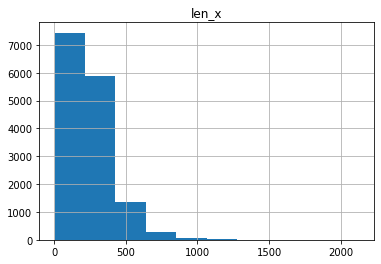

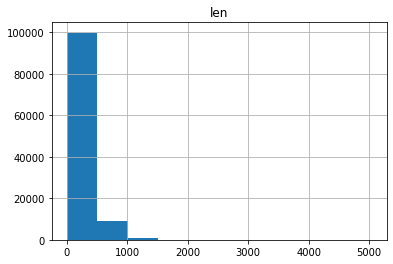

In [9]:
ss_2022_25_20.hist(column='len_x')
ss_2022_25_25.hist(column='len_x')
ss_2022_30_25.hist(column='len_x')
ss_cleaned.hist(column='len')
plt.show()

In [3]:
# what fraction of sequences are within desired ranges?
pd.DataFrame({'Dataset': ['ss_2022_25_20', 'ss_2022_25_25', 'ss2022_30_25', 'ss_cleaned'],
              'Total Sequences': [len(ss_2022_25_20), len(ss_2022_25_25), len(ss_2022_30_25), len(ss_cleaned)],
              f'Sequences {min_len} <= length <= {max_len}': [len(ss_2022_25_20.query(f'len_x >= {min_len} & len_x <= {max_len}')),
                                                            len(ss_2022_25_25.query(f'len_x >= {min_len} & len_x <= {max_len}')),
                                                            len(ss_2022_30_25.query(f'len_x >= {min_len} & len_x <= {max_len}')),
                                                            len(ss_cleaned.query(f'len >= {min_len} & len <= {max_len}'))],
              f'Fraction Between {min_len} and {max_len} aa': [len(ss_2022_25_20.query(f'len_x >= {min_len} & len_x <= {max_len}')) / len(ss_2022_25_20),
                                                             len(ss_2022_25_25.query(f'len_x >= {min_len} & len_x <= {max_len}')) / len(ss_2022_25_25),
                                                             len(ss_2022_30_25.query(f'len_x >= {min_len} & len_x <= {max_len}')) / len(ss_2022_30_25),
                                                             len(ss_cleaned.query(f'len >= {min_len} & len <= {max_len}')) / len(ss_cleaned)]}).round(3)

,Dataset,Total Sequences,Sequences 100 <= length <= 300,Fraction Between 100 and 300 aa
0,ss_2022_25_20,8313,4858,0.584
1,ss_2022_25_25,10931,6272,0.574
2,ss2022_30_25,15079,8683,0.576
3,ss_cleaned,109786,56304,0.513


In [4]:
# query samples of aa between 100-300 from ss_2022_30_25
ss_2530 = ss_2022_30_25.query(f'len_x >= {min_len} & len_x <= {max_len}')
test_seqs = ss_2530.seq.tolist() 
test_sst3 = ss_2530.sst3.tolist()

# query samples of aa between 100-300 from cleaned dataset
ss_all = ss_cleaned.query(f'len >= {min_len} & len <= {max_len} & not has_nonstd_aa')
ss_all_seqs = ss_all.seq.tolist()
ss_all_sst3 = ss_all.sst3.tolist()

# remove any overlap between train and test dataset
train_idx = [i for i, seq in enumerate(ss_all_seqs) if seq not in test_seqs]
train_seqs = [ss_all_seqs[i] for i in train_idx]
train_sst3 = [ss_all_sst3[i] for i in train_idx]

# randomly sample from train to valid dataset
valid_idx = random.sample(range(len(train_seqs)), int(len(train_seqs) * .25))
valid_seqs = [train_seqs[i] for i in valid_idx]
valid_sst3 = [train_sst3[i] for i in valid_idx]

# remove overlap between train and valid dataset
train_seqs = [seq for i, seq in enumerate(train_seqs) if i not in valid_idx]
train_sst3 = [sst3 for i, sst3 in enumerate(train_sst3) if i not in valid_idx]

print('Training set size: ', len(train_seqs))
print('Validation set size: ', len(valid_seqs))
print('Test set size: ', len(test_seqs))

Training set size:  41518
Validation set size:  13839
Test set size:  8683


In [5]:
def seq2kmers(seqs, n = 3):
    return np.array([[seq[i:i+n] for i in range(len(seq))] for seq in seqs], dtype = object)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

# generate k-mers from protein sequences
train_kmers = seq2kmers(train_seqs, n = kmer_size)
valid_kmers = seq2kmers(valid_seqs, n = kmer_size)

# encode the protein sequences
encoder = Tokenizer()
encoder.fit_on_texts(train_kmers)
X_train = encoder.texts_to_sequences(train_kmers)
X_train = sequence.pad_sequences(X_train, maxlen = max_len, padding = 'post')

X_valid = encoder.texts_to_sequences(valid_kmers)
X_valid = sequence.pad_sequences(X_valid, maxlen = max_len, padding = 'post')

# encode the target secondary structures as categorical
decoder = Tokenizer(char_level = True)
decoder.fit_on_texts(train_sst3)
y_train = decoder.texts_to_sequences(train_sst3)
y_train = sequence.pad_sequences(y_train, maxlen = max_len, padding = 'post')
y_train = to_categorical(y_train)

y_valid = decoder.texts_to_sequences(valid_sst3)
y_valid = sequence.pad_sequences(y_valid, maxlen = max_len, padding = 'post')
y_valid = to_categorical(y_valid)

In [7]:
tf.__version__

'2.9.0'

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, Embedding, Dense, TimeDistributed, Bidirectional

n_words = len(encoder.word_index) + 1
n_ssts = len(decoder.word_index) + 1

In [9]:
bidir_model = Sequential()
bidir_model.add(Embedding(input_dim = n_words, output_dim = 128, input_length = max_len))
bidir_model.add(Bidirectional(GRU(units = 64, return_sequences = True, recurrent_dropout = 0.1)))
bidir_model.add(TimeDistributed(Dense(n_ssts)))

bidir_model.summary()

Metal device set to: Apple M1 Pro


2024-04-16 01:18:58.105425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-16 01:18:58.106142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1077888   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 128)         74496     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 300, 4)           516       
 ibuted)                                                         
                                                                 
Total params: 1,152,900
Trainable params: 1,152,900
Non-trainable params: 0
_________________________________________________________________


In [10]:
# model = Sequential([
#     Embedding(input_dim = n_words, output_dim = 128, input_length = max_len),
#     Bidirectional(GRU(units = 64, return_sequences = True, recurrent_dropout = 0.1)),
#     TimeDistributed(Dense(n_ssts, activation = 'softmax'))])

# model.summary()

In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
# from sklearn.model_selection import train_test_split
from keras import backend as K

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

bidir_model.compile(optimizer = SGD(), loss = CategoricalCrossentropy(), metrics = ["accuracy", q3_acc])

In [12]:
bidir_model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, y_valid), verbose = 1)

Epoch 1/10


2024-04-16 01:19:04.835165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-16 01:19:07.000849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<128x300x1x4xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must

108/325 [========>.....................] - ETA: 22:15:40 - loss: 1.3385 - accuracy: 0.0508 - q3_acc: 0.0790

KeyboardInterrupt: 

In [12]:
from sklearn.model_selection import train_test_split
from keras import backend as K

def q3_acc(y_true, y_pred):
    y = tf.argmax(y_true, axis=-1)
    y_ = tf.argmax(y_pred, axis=-1)
    mask = tf.greater(y, 0)
    return K.cast(K.equal(tf.boolean_mask(y, mask), tf.boolean_mask(y_, mask)), K.floatx())

model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy", q3_acc])
model.fit(x = X_train, y = y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, y_valid), verbose = 1)

Epoch 1/10


2024-03-25 21:46:08.605719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<128x300x1x4xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<128x300x1x4xi1

KeyboardInterrupt: 

In [ ]:
test_kmers = seq2kmers(test_seqs, n = kmer_size)
X_test = encoder.texts_to_sequences(test_kmers)
X_test = sequence.pad_sequences(X_test, maxlen = maxlen, padding = 'post')

# encode the target secondary structures as categorical
y_test = decoder.texts_to_sequences(test_sst3)
y_test = sequence.pad_sequences(y_test, maxlen = maxlen, padding = 'post')
y_test = to_categorical(y_test)

# reversal functions from https://www.kaggle.com/code/helmehelmuto/secondary-structure-prediction-with-keras
def onehot_to_seq(oh_seq, index):
    s = ''
    for o in oh_seq:
        i = np.argmax(o)
        if i != 0:
            s += index[i]
        else:
            break
    return s

reverse_decoder_index = {value:key for key,value in decoder.word_index.items()}

In [ ]:
test_preds = model.predict(X_test)

# compute overall Q3 Accuracy
q3 = 0
total_count = 0
for i, pred in enumerate(test_preds):
    acc = q3_acc(y_test[i], pred)
    q3 += np.sum(acc)
    total_count += len(acc)
    
print('Test Set Q3 Accuracy: ', np.round(q3 / total_count, 2))

In [ ]:
for index in [1, 10, 100, 1000]:
    actual = onehot_to_seq(y_test[index], reverse_decoder_index)
    predicted = onehot_to_seq(test_preds[index], reverse_decoder_index)
    match = ''.join(['*' if a == p else '-' for a, p in zip(actual, predicted) ])
    acc = q3_acc(y_test[index], test_preds[index])
    
    print('Example #', index)
    print('Q3 Accuracy: ', np.round(np.sum(acc) / len(acc), 2))
    print('Actual:\t', actual + '\n' + 
          'Match:\t\t', match + '\n' + 
          'Predicted:\t', predicted + '\n' +
          '\t\t ' + ''.join(['|' if (n + 1) % 10 == 0 else '-' for n in range(len(actual))]))